In [129]:
%pip install gdown
%pip install sklearn
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install tensorflow
%pip install seaborn
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [130]:
!gdown 1q25DeCsOr7dScSEFvN6WULYjGN0Rrf0b -O /tmp/forestfires.csv

Downloading...
From: https://drive.google.com/uc?id=1q25DeCsOr7dScSEFvN6WULYjGN0Rrf0b
To: c:\tmp\forestfires.csv

  0%|          | 0.00/25.5k [00:00<?, ?B/s]
100%|██████████| 25.5k/25.5k [00:00<?, ?B/s]


In [131]:
import pandas as pd
df = pd.read_csv('/tmp/forestfires.csv')
df['area'] = np.log1p(df['area'])
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


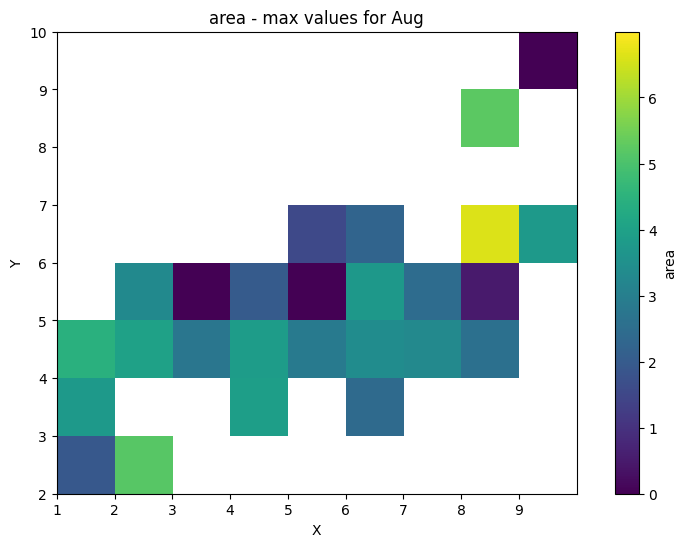

In [132]:
import matplotlib.pyplot as plt
import numpy as np
def plot_grid(month, column_name, func='mean'):
    filtered_df = df[df['month'] == month]
    if func == 'mean':
        agg_values = filtered_df.groupby(['X', 'Y'])[column_name].mean().reset_index()
    elif func == 'min':
        agg_values = filtered_df.groupby(['X', 'Y'])[column_name].min().reset_index()
    elif func == 'max':
        agg_values = filtered_df.groupby(['X', 'Y'])[column_name].max().reset_index()
    else:
        raise ValueError("Invalid 'func' parameter. Choose from 'mean', 'min', or 'max'.")
    grid = np.full((8, 9), np.nan)
    for _, row in agg_values.iterrows():
        x = int(row['X']) - 1
        y = int(row['Y']) - 2
        grid[y, x] = row[column_name]
    plt.figure(figsize=(10, 6))
    plt.imshow(grid, cmap='viridis', origin='lower', extent=[1, 10, 2, 10], vmin=np.nanmin(df[column_name]), vmax=np.nanmax(df[column_name]))
    plt.colorbar(label=column_name)
    plt.title(f'{column_name} - {func} values for {month.capitalize()}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xticks(np.arange(1, 10))
    plt.yticks(np.arange(2, 11))
    plt.grid(visible=False)
    plt.show()
plot_grid('aug', 'area', 'max')

In [133]:
from sklearn.model_selection import train_test_split
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
day_mapping = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7}
df['month'] = df['month'].map(month_mapping)
df['day'] = df['day'].map(day_mapping)
df.fillna(df.mean(), inplace=True)
y = df['area']
X = df.drop(columns=['area'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (413, 12)
X_test shape: (104, 12)
y_train shape: (413,)
y_test shape: (104,)


In [134]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.2, 0.4],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'random_state': [42]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test_scaled)
xgb_rmse = mean_squared_error(y_test, y_pred, squared=False)
y_pred_original_scale = np.expm1(y_pred)
xgb_rmse2 = mean_squared_error(np.expm1(y_test), y_pred_original_scale, squared=False)
print("XGBoost RMSE for log(area) and area:", xgb_rmse, xgb_rmse2)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
XGBoost RMSE for log(area) and area: 1.515816157099223 109.93298024362447
